In [1]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
# Setup seeds
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

### Generator 및 Discriminator 구현 

In [3]:
class Generator(nn.Module):

    def __init__(self, z_dim=20):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1,
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh())
        # 주의 : 흑백 화상이므로 출력 채널은 하나

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)

        # 전치 합성곱 층에 넣으므로 tensor 형태로 변경
        out = out.view(z.shape[0], 128, 7, 7)
        out = self.layer3(out)
        out = self.last(out)

        return out

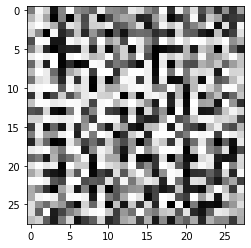

In [4]:
# 동작 확인
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20)
G.train()

# 입력 난수
# 배치 정규화가 잇어 미니 배치 수는 2 이상
input_z = torch.randn(2, 20)

# 가짜 화상 출력 
fake_images = G(input_z)  # torch.Size([2, 1, 28, 28])
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [5]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()

        # 화상 측 입력 처리
        self.x_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 주의 : 흑백 화상이므로 입력 채널은 하나 

        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        # 난수 측 입력 처리 
        self.z_layer1 = nn.Linear(z_dim, 512)

        # 최후 판정 
        self.last1 = nn.Sequential(
            nn.Linear(3648, 1024),
            nn.LeakyReLU(0.1, inplace=True))

        self.last2 = nn.Linear(1024, 1)

    def forward(self, x, z):

        # 화상 측 입력 처리 
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)

        # 난수 측 입력 처리 
        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)

        # x_out과 z_out을 결합하여 전결합 층에서 판정 
        x_out = x_out.view(-1, 64 * 7 * 7)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)

        feature = out  # 마지막에 채널을 하나로 집약
        feature = feature.view(feature.size()[0], -1)  # 2차원으로 변환 

        out = self.last2(out)

        return out, feature

In [6]:
# 동작 학인
D = Discriminator(z_dim=20)

# 가짜 화상 생성 
input_z = torch.randn(2, 20)
fake_images = G(input_z)

# 가짜 화상을 D에 입력 
d_out, _ = D(fake_images, input_z)

# 출력 d_out에 Sigmoid를 곱하여 0에서 1로 변환
print(nn.Sigmoid()(d_out))

tensor([[0.4322],
        [0.4629]], grad_fn=<SigmoidBackward>)


### Encoder 구현 

In [7]:
class Encoder(nn.Module):

    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3,
                      stride=1),
            nn.LeakyReLU(0.1, inplace=True))
         # 주의 : 흑백 화상이므로 입력 채널은 하나 

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True))

        # 여기가지 화상 크기는 7X7 이 된다 
        self.last = nn.Linear(128 * 7 * 7, z_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        # FC에 넣기 위해 텐서 모양으로 변경 
        out = out.view(-1, 128 * 7 * 7)
        out = self.last(out)

        return out

In [8]:
# 확인
E = Encoder(z_dim=20)

# 입력할 화상 데이터 
x = fake_images  # fake_images는 위에서 G로 작성한것 

# 화상에서 z를 인코드
z = E(x)

print(z.shape)
print(z)

torch.Size([2, 20])
tensor([[-0.0669, -0.2844, -0.3601,  0.1404, -0.2922, -0.4834, -0.0025,  0.0258,
         -0.1298, -0.2613, -0.4292, -0.2584, -0.6141, -0.1440,  0.1142,  0.2175,
          0.0730,  0.0323, -0.7176, -0.7410],
        [ 0.4822,  0.3681, -0.0647, -0.0773,  0.0989,  0.3012,  0.8054,  0.4399,
          1.0848, -0.2809,  0.0619, -0.3179, -0.2963, -0.1192,  0.6562, -0.1707,
          0.1287, -0.6156,  0.3127, -0.4818]], grad_fn=<AddmmBackward>)


### DataLoader 구현 

In [9]:
def make_datapath_list():
    train_img_list = list()  

    for img_idx in range(200):
        img_path = "./data/img_78_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

In [10]:
class ImageTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [11]:
class GAN_Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):

        img_path = self.file_list[index]
        img = Image.open(img_path)  

        img_transformed = self.transform(img)

        return img_transformed

In [12]:
# DataLoader
train_img_list=make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)  
imges = next(batch_iterator)  
print(imges.size())  # torch.Size([64, 1, 64, 64])

torch.Size([64, 1, 28, 28])


### Efficient Gan 학습 

In [17]:
# 모델을 학습시키는 함수 작성 
def train_model(G, D, E, dataloader, num_epochs):

    # GPU 사용 확인 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치：", device)

    # 최적화 기법 설정
    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    # 오차 함수 정의 
    # BCEWithLogitsLoss는 입력에 시그모이드(logit）를 곱한뒤 
    # 이진 크로스 엔트로피 계산
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 파라미터 
    z_dim = 20
    mini_batch_size = 64

    # GPU
    G.to(device)
    E.to(device)
    D.to(device)

    G.train()  # 모델을 훈련 모드로
    E.train()  # 모델을 훈련 모드로
    D.train()  # 모델을 훈련 모드로

    # 네트워크가 어느 정도 고정되면 고속화 한다 
    torch.backends.cudnn.benchmark = True

    # 화상 매수 
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운터 
    iteration = 1
    logs = []

    # epoch
    for epoch in range(num_epochs):

        # 개시 시간 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch손실 합
        epoch_e_loss = 0.0  # epoch손실 합
        epoch_d_loss = 0.0  # epoch손실 합

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # 데이터 로더에서 미니 배치씩 꺼내는 루프
        for imges in dataloader:

            # 미니 배치 크기가 1이면, 배치 정규화에서 오류가 발생하여 피한다 
            if imges.size()[0] == 1:
                continue

            # 미니 배치 크기의 1 또는 0의 라벨 역할의 텐서 작성
            # 정답 라벨과 가짜 라벨 작성 
            # epoch의 마지막 반복은 미니 배치 수가 줄어든다 
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)
            
            # [error]형변환 에러로 추가 
            label_real = label_real.float()
            label_fake = label_fake.float()
            
            # GPU를 사용할 수 있으면 GPU로 데이터를 보낸다 
            imges = imges.to(device)

            # --------------------
            # 1. Discriminator학습 
            # --------------------
            # 진짜 화상 판정 
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 가짜 화상을 생성하여 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 오차 계산 
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # 역전파 
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습 
            # --------------------
            # 가짜 화상을 생성하여 판정 
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 오차 계산 
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # 역전파
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. Encoder학습 
            # --------------------
            # 진짜 화상 z 추정 
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 오차 계산 
            e_loss = criterion(d_out_real.view(-1), label_fake)

            # 역전파
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

            # --------------------
            # 4. 기록 
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1

        # epoch의 phase별 loss과 정답률 
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    print("총 반복 횟수 :", iteration)

    return G, D, E

In [18]:
# 네트워크 초기화 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # conv2d와 ConvTranspose2d 초기화 
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d 초기화 
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        # 전 결합 층 Linear 초기화 
        m.bias.data.fill_(0)


# 초기화 실시 
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print("네트워크 초기화 완료 ")

네트워크 초기화 완료 


In [19]:
# 학습 및 검증 실행 
num_epochs = 1500
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)

사용 장치： cuda:0
-------------
Epoch 0/1500
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.1483 ||Epoch_G_Loss:0.0786 ||Epoch_E_Loss:0.0767
timer:  0.4197 sec.
-------------
Epoch 1/1500
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.1449 ||Epoch_G_Loss:0.0812 ||Epoch_E_Loss:0.0784
timer:  0.3255 sec.
-------------
Epoch 2/1500
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.1406 ||Epoch_G_Loss:0.0831 ||Epoch_E_Loss:0.0809
timer:  0.3224 sec.
-------------
Epoch 3/1500
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.1364 ||Epoch_G_Loss:0.0850 ||Epoch_E_Loss:0.0841
timer:  0.3249 sec.
-------------
Epoch 4/1500
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.1330 ||Epoch_G_Loss:0.0865 ||Epoch_E_Loss:0.0862
timer:  0.3238 sec.
-------------
Epoch 5/1500
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.1302 ||Epoch_G_Loss:0.0880 ||Epoch_E_Loss:0.0885
timer:  0.3323 sec.
-------------
Epoch 6/1500
-----------

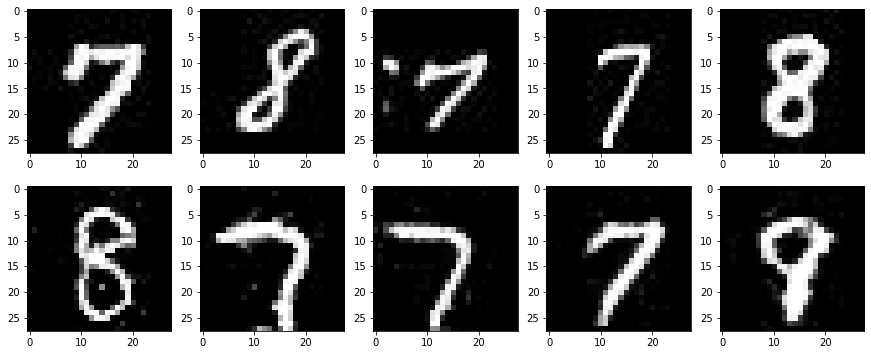

In [20]:
# 생성 화상과 훈련 화상 시각화 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 입력 난수 생성 
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 훈련 데이터 
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 출력 
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터 표시 
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터 표시 
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

### EfficientGAN을 활용한 이상 탐지 

In [21]:
# DataLoader


def make_test_datapath_list():

    train_img_list = list() 

    for img_idx in range(5):
        img_path = "./data/test_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

test_img_list = make_test_datapath_list()

mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

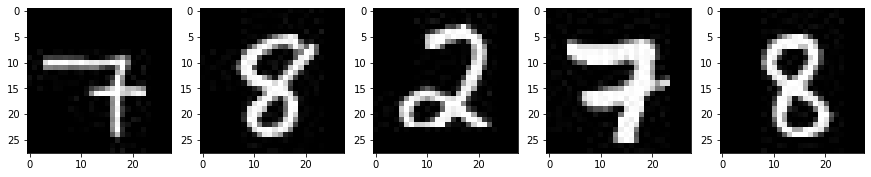

In [22]:
batch_iterator = iter(test_dataloader)  
imges = next(batch_iterator)  

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

In [23]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):

    # 테스트 화상 x 와 생성화상 fake_img의 픽셀 수준 차이의 절댓값을 계산하여 미니배치마다 합을 구함 
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    # 테스트 화상 x와 생성 화상 fake_img를 식별기 D에 입력하여 특징량 맵을 꺼낸다 
    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)

    # 테스트 화상 x 와 생성화상 fake_img의 픽셀 수준 차이의 절댓값을 계산하여 미니배치마다 합을 구함 
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(
        discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    # 미니 배치마다 두 종류의 손실을 더함 
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    # 모든 미니 배치의 손실을 구함
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss

total loss： [186. 202. 276. 260. 161.]


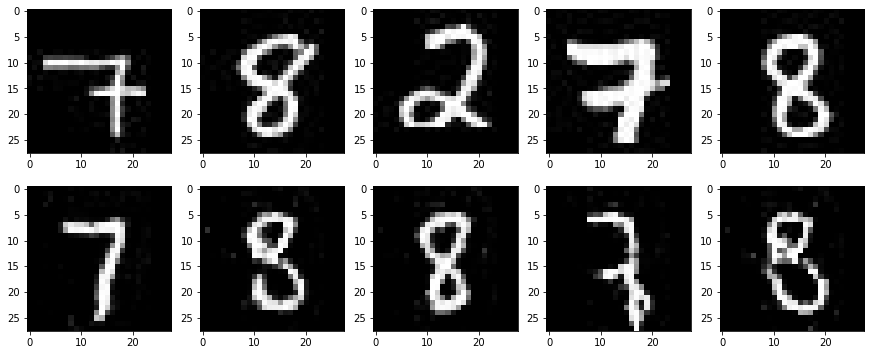

In [24]:
# 이상 탐지할 화상 
x = imges[0:5]
x = x.to(device)

# 지도 데이터의 화상을 인코드 하여 z로 한 후 G에서 생성 
E_update.eval()
G_update.eval()
z_out_real = E_update(imges.to(device))
imges_reconstract = G_update(z_out_real)

# 손실을 구함 
loss, loss_each, residual_loss_each = Anomaly_score(
    x, imges_reconstract, z_out_real, D_update, Lambda=0.1)

# 손실 게산, 총 손실 
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

# 화상의 시각화 
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터 표시 
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터 표시 
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i][0].cpu().detach().numpy(), 'gray')